In [1]:
#loading yeast groundtruth 0 data
yeast=open("yeast_residual_data_full_1000_gt_2.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,1000):
  line=yeast.readline()
  #line=line[1:-2] #remove double quotes 
  #param = [j for j in line.split()]
  #print(param)
  #chrname.append(param[1])
  #g1.append(param[2])
  #g2.append(param[3])
  line=yeast.readline()
  l = [j for j in line.split()]
  L.append([int(i) for i in l])
  line=yeast.readline()
  a = [j for j in line.split()]
  A.append([float(i) for i in a])
  line=yeast.readline()
  b = [j for j in line.split()]
  B.append([float(i) for i in b])
dataset_0 = [i for i in zip(L,A,B)]


In [2]:
#loading yeast groundtruth 1 data
yeast=open("yeast_residual_data_full_1000_gt_1.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,1000):
  line=yeast.readline()
  #line=line[1:-2] #remove double quotes 
  #param = [j for j in line.split()]
  #print(param)
  #chrname.append(param[1])
  #g1.append(param[2])
  #g2.append(param[3])
  line=yeast.readline()
  l = [j for j in line.split()]
  L.append([int(i) for i in l])
  line=yeast.readline()
  a = [j for j in line.split()]
  A.append([float(i) for i in a])
  line=yeast.readline()
  b = [j for j in line.split()]
  B.append([float(i) for i in b])
dataset_1 = [i for i in zip(L,A,B)]

#reshapefunction



In [3]:
#loading the libraries
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import rpy2

2022-03-15 20:58:45.170546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 20:58:45.170582: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
#loading the rpy2 pacakge to use the R package nlcor
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
nlcor=importr('nlcor')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [5]:
#defining the class MDN
class MDN_module(tf.keras.Model):

    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [6]:
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [7]:
def compute_loss(P,Q):
  """ Compute the loss for the given pair
  """
  opt = tf.optimizers.Adam(1e-2)
  mdn_PQ = MDN_module()
  mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
  mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
  return eval_mdn_model(P,Q,mdn_PQ)


In [8]:
def shuffleBtimes(P,Q,B):
  """ Shuffle Q B times and compute the loss 
  """
  loss=[]
  for i in range(0,B):
      loss.append(compute_loss(P,np.random.permutation(Q)))
  return loss


In [31]:
def LinearLABData():
  """ Generate the linear data 
  """
  L = np.random.binomial(1,0.5,1000)  
  beta0 = np.ones(1000)-0.4
  #beta1 = 0.5
  beta1=3
  beta2= 0.3
  beta3=0.8
  eps0 = np.random.standard_normal(1000)
  eps1 = np.random.standard_normal(1000)
  A = beta0 + beta1*L + eps0
  B = beta2+ beta3*A# + eps1 
  plt.scatter(A,B)
  plt.title("A vs B")
  plt.xlabel("A")
  plt.ylabel("B")
  return [L,A,B]

In [14]:
def residual(P,Q):
  """ Calculate the residual 
  """
  #opt = tf.optimizers.Adam(1e-2)
  #mdn_PQ = MDN_module()
  #mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
  #mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
  #y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
  model=sm.OLS(Q,P).fit() 
  print(model.resid)
  return model.resid #Linear residual
  #non linear residual
 # print(y_pred)
  #print(Q)
 #print(Q-y_pred[:,1])
  #return (Q-y_pred[:,1])
  

In [11]:
yeast_name=""
def yeast_data(i,ind):
    '''
    Function to return the trios with the gndtruth 0/1 based on i and the number based on ind 
    '''
    global yeast_name
    yeast_name="yeast_"+str(i)+"_"+str(ind)
    ds = eval("dataset_"+str(i)+"["+str(ind)+"]")
    L_dist = np.array(ds[0]) #np.array(ds[0])
    A_dist = np.array(ds[1])
    B_dist = np.array(ds[2])
    plt.scatter(A_dist,B_dist)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L_dist,A_dist,B_dist]

In [57]:
def calculate_pvalue(original,loss_list,test):
    '''
    calculate the p value 
    '''
    if(test==1 or test==2):
        return sum(i < original for i in loss_list)/len(loss_list)
    
    return sum(i > original for i in loss_list)/len(loss_list)
    

In [12]:
def stratify_B_n_times(L,A,B,n):
    '''
    Stratify B wrt to L
    '''
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):
      
      B_dist_temp=np.zeros(len(B))
      mod_indices_1=random.sample(indices_1,len(indices_1))
      for i in range(len(indices_1)):
        B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

      mod_indices_0=random.sample(indices_0,len(indices_0))
      for i in range(len(indices_0)):
        B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
      #print(B_dist_temp)
      loss.append(compute_loss(L,residual(A,B_dist_temp)))

    return loss 




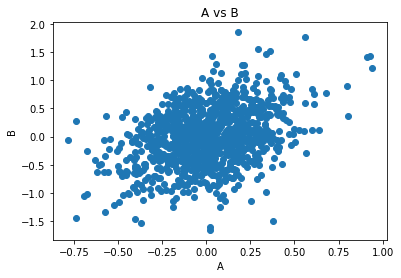

In [109]:
random.seed(24)
shuffles=10
#L,A,B=LinearLABData()
L,A,B=yeast_data(1,444)


In [63]:

A_shuffle=np.copy(A)
B_shuffle=np.copy(B)
#print("Original",B_shuffle)
loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles)
loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles)
loss_list_Bresidual=stratify_B_n_times(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
true_LA=compute_loss(L,A)
true_LB=compute_loss(L,B)
#print("Next",B_shuffle)
true_LBresidual=compute_loss(L,residual(A,B_shuffle))
print(calculate_pvalue(true_LA,loss_list_LA,1))
print(calculate_pvalue(true_LB,loss_list_LB,2))
print(calculate_pvalue(true_LBresidual,loss_list_Bresidual,3))
#true_LindB_A=compute_loss(L,B_resid)


Original [ 2.84688604e+00  1.08715240e+00  5.01197545e+00  6.03743141e-01
  2.35136226e+00  1.90531318e+00  8.70858738e-01  4.22670034e+00
  8.73718234e-01  3.11694602e-01  2.22326455e+00  7.97987910e-01
  3.19698756e+00  3.97303034e+00  4.44156768e-02  2.49751329e+00
  3.92373934e+00  1.45396332e+00  2.77058059e-01  4.14830846e-01
  1.49664182e+00 -8.60013480e-02  2.99276885e+00  2.88047877e+00
  3.20741100e+00  3.99135072e+00  2.86663411e-01  3.56238531e+00
  3.77041929e+00  7.95673906e-01 -1.78258100e-01  1.00625088e+00
  4.67970895e+00  2.50750646e+00 -3.12487997e-01  1.11807225e+00
  2.17794981e+00  9.87281616e-01  1.15775514e+00  2.53815922e+00
  2.85402045e+00  5.75472453e-01  1.87456628e+00  3.67378255e+00
  5.65603129e-01  2.62320342e+00  3.55089782e+00 -4.29374065e-01
  3.34447174e-01  2.45693722e+00  2.22992403e+00  1.77444989e+00
 -2.68194609e-01  8.83370549e-01  2.61058854e+00  3.32402402e+00
 -1.15562354e+00 -1.19783033e+00 -3.68129078e-01  3.77979044e+00
  1.78431994e+00

[ 3.18360755e+00  9.83940504e-01  5.88996931e+00  3.79678926e-01
  2.56420282e+00  2.00664147e+00  7.13573422e-01  4.90837543e+00
  7.17147792e-01  1.46182529e-02  2.40408069e+00  6.22484888e-01
  3.62123445e+00  4.59128792e+00 -3.19480404e-01  2.74689161e+00
  4.52967418e+00  1.44245415e+00 -2.86774268e-02  1.43538557e-01
  1.49580228e+00 -4.82501685e-01  3.36596106e+00  3.22559846e+00
  3.63426375e+00  4.61418840e+00 -1.66707368e-02  4.07798164e+00
  4.33802412e+00  6.19592382e-01 -5.97822625e-01  8.82813598e-01
  5.47463618e+00  2.75938308e+00 -7.65609996e-01  1.02259031e+00
  2.34743726e+00  8.59102020e-01  1.07219392e+00  2.79769902e+00
  3.19252556e+00  3.44340566e-01  1.96820785e+00  4.21722819e+00
  3.32003911e-01  2.90400428e+00  4.06362228e+00 -9.11717582e-01
  4.30589675e-02  2.69617152e+00  2.41240504e+00  1.84306236e+00
 -7.10243261e-01  7.29213186e-01  2.88823567e+00  3.78003003e+00
 -1.81952943e+00 -1.87228792e+00 -8.35161347e-01  4.34973805e+00
  1.85539992e+00  4.05434

[ 2.84688604e+00  1.08715240e+00  5.01197545e+00  6.03743141e-01
  2.35136226e+00  1.90531318e+00  8.70858738e-01  4.22670034e+00
  8.73718234e-01  3.11694602e-01  2.22326455e+00  7.97987910e-01
  3.19698756e+00  3.97303034e+00  4.44156768e-02  2.49751329e+00
  3.92373934e+00  1.45396332e+00  2.77058059e-01  4.14830846e-01
  1.49664182e+00 -8.60013480e-02  2.99276885e+00  2.88047877e+00
  3.20741100e+00  3.99135072e+00  2.86663411e-01  3.56238531e+00
  3.77041929e+00  7.95673906e-01 -1.78258100e-01  1.00625088e+00
  4.67970895e+00  2.50750646e+00 -3.12487997e-01  1.11807225e+00
  2.17794981e+00  9.87281616e-01  1.15775514e+00  2.53815922e+00
  2.85402045e+00  5.75472453e-01  1.87456628e+00  3.67378255e+00
  5.65603129e-01  2.62320342e+00  3.55089782e+00 -4.29374065e-01
  3.34447174e-01  2.45693722e+00  2.22992403e+00  1.77444989e+00
 -2.68194609e-01  8.83370549e-01  2.61058854e+00  3.32402402e+00
 -1.15562354e+00 -1.19783033e+00 -3.68129078e-01  3.77979044e+00
  1.78431994e+00  3.54347

[ 4.75343261e+00 -3.68951863e-03  2.43589398e+00  4.08486188e-01
  9.83946156e-01  8.21071539e-01  3.43360631e-01  3.65002798e+00
 -2.52947485e-02  1.54684182e+00  6.78901013e-01  2.83840089e+00
  3.08707661e+00  2.95698991e+00 -9.97902057e-01  3.27765887e+00
  2.76687499e+00  8.73718234e-01  5.27682511e-01  1.02338176e+00
  1.64799833e-01  8.90713454e-01  2.80924168e+00  3.36896199e+00
  2.27355668e+00  3.09175776e+00  2.30857525e+00  4.00298469e+00
  3.85098157e+00 -2.32511448e-01  8.65241210e-01  1.90744135e-01
  2.94523634e+00  2.52433134e+00  2.82692763e+00 -1.92935274e-01
  2.62320342e+00  3.91375496e-01  9.35896668e-01  2.91766903e+00
  4.30888932e+00 -1.49949600e-01  2.21449367e+00  3.10454880e+00
  1.78183436e+00  2.88194245e+00  2.81772512e+00 -6.83204224e-01
  2.38297004e+00  3.34852397e+00  1.53200116e+00  5.75472453e-01
  4.78638597e-01  9.81065001e-01  3.42214641e+00  4.82662748e+00
  1.74527903e+00  1.45032234e+00  1.43796505e+00  2.56347492e+00
  1.50043065e+00  3.53260

[ 3.12343129e+00 -2.51101865e-01  2.98589269e+00  1.13448538e+00
  1.63271915e+00  9.29559932e-01  1.90531318e+00  2.67902727e+00
  2.02713799e+00  1.17754292e+00  1.55119661e+00  1.22757811e+00
  2.96404211e+00  3.63898927e+00  2.11949055e-01  3.77433953e+00
  2.79784639e+00  1.57301568e+00  9.35896668e-01  8.70858738e-01
  1.45032234e+00  9.07862422e-01  2.27176331e+00  3.57117216e+00
  2.53235517e+00  3.31981418e+00  2.44662466e-01  3.27185698e+00
  4.04534496e+00 -8.51640802e-02 -1.18010557e+00  1.57993980e+00
  2.96035820e+00  3.55309543e+00  1.43410995e+00  5.51226200e-01
  2.48062520e+00  1.09957791e+00  8.72564884e-01  3.84039499e+00
  2.33160215e+00 -1.16496249e+00  8.23374775e-01  2.68744395e+00
  8.05521623e-01  3.30292976e+00  3.41807058e+00  2.86663411e-01
  6.39267282e-01  3.44658473e+00  1.63218950e+00  3.12248565e-01
  2.29034926e+00  1.88326049e+00  3.80478312e+00  3.04876202e+00
  1.66013124e+00  1.82726901e+00  2.03932271e+00  1.99492732e+00
  8.83370549e-01  4.11882

[ 4.80942536e+00  2.99226245e-01  3.21598493e+00 -1.03617665e+00
  8.36276732e-01 -6.04056302e-01  1.65221906e+00  3.31221788e+00
  1.20411991e+00  1.23324139e-01  1.52142108e+00  1.57449358e+00
  2.94877134e+00  3.84297279e+00  9.88895807e-01  2.55035441e+00
  2.74266246e+00  1.42945493e-01  1.94331221e+00  2.12729868e+00
 -1.01178239e+00  1.21950675e+00  3.82038309e+00  2.67147686e+00
  3.20741100e+00  2.80332770e+00  6.27876760e-02  2.10574339e+00
  3.49883452e+00  1.77444989e+00 -5.65692897e-01  2.18435020e+00
  3.28709701e+00  2.86439380e+00  1.06026491e+00  1.06002617e+00
  2.52676796e+00 -6.83204224e-01  2.82692763e+00  3.57183246e+00
  2.39847566e+00  9.34389270e-01  1.21102059e+00  3.00294857e+00
  2.77058059e-01  3.66442101e+00  2.34522350e+00  5.91771056e-01
  1.82726901e+00  3.30511185e+00  3.15782587e+00  2.81124215e-01
  5.13243342e-02  5.65509851e-02  4.88826783e+00  3.23216234e+00
  1.45764575e+00  1.64761131e-01  4.71772466e-01  2.35973900e+00
  1.05932065e+00  3.33375

[ 3.92529512e+00  1.40539969e+00  2.84892186e+00  5.04764341e-01
  3.81884691e-01  8.67947796e-01  1.95308529e-01  2.45693722e+00
 -1.16496249e+00  5.65603129e-01  1.26718587e+00 -3.40460500e-01
  2.88159338e+00  2.07879744e+00  9.42429239e-01  2.17794981e+00
  3.57425749e+00  1.08712432e+00  3.42761198e-01  1.21572120e+00
  8.41176675e-01  2.22992403e+00  2.50639300e+00  2.05868625e+00
  4.36209208e+00  1.97426083e+00  2.25010291e+00  3.15072631e+00
  2.31965275e+00  1.08743354e+00  2.77286555e-02  2.11709409e-01
  4.00298469e+00  3.48781183e+00  9.94224363e-01 -3.01881683e-01
  3.58917102e+00 -1.15939453e+00  2.20670565e+00  2.46899570e+00
  2.50573864e+00  2.12729868e+00  1.33816232e+00  2.72818509e+00
  9.07862422e-01  3.92972721e+00  3.19698756e+00  1.18997349e+00
 -6.83204224e-01  3.03739471e+00  8.32492787e-01 -8.51640802e-02
  7.95018805e-01 -1.19783033e+00  4.53752219e+00  3.93059334e+00
 -8.82645906e-02  2.02713799e+00  4.67251502e-01  1.66739739e+00
  1.01216446e+00  1.84938

[ 3.84124171e+00  4.95583465e-01  3.69588835e+00  1.31012208e+00
  9.68866526e-01  8.83370549e-01  1.00166543e+00  2.14138082e+00
  2.10445353e+00 -3.05490236e-01 -1.78258100e-01  1.90531318e+00
  3.33005024e+00  2.12720238e+00  1.25057731e+00  2.00597618e+00
  4.07850297e+00  8.87733605e-01  7.86980208e-01  2.17598777e+00
  1.42550114e+00  1.12222624e+00  3.23135260e+00  3.37674806e+00
  4.56496958e+00  2.75797725e+00 -7.58698396e-01  3.02233037e+00
  4.13723899e+00  1.55119661e+00 -1.18010557e+00  4.71772466e-01
  4.76361992e+00  3.93659314e+00  1.41071942e+00  2.18435020e+00
  3.43704641e+00  1.78431994e+00  1.83950722e+00  3.60701769e+00
  2.68744395e+00  8.32492787e-01 -8.61564891e-01  3.47289227e+00
 -5.52983211e-01  3.21598493e+00  1.88689189e+00  2.01890153e+00
  9.24399036e-01  2.39351202e+00 -9.85167066e-01  1.81314672e+00
  1.30550467e+00  1.99193979e+00  3.82504048e+00  2.48084501e+00
  1.06026491e+00  7.19271211e-01  1.09957791e+00  3.77041929e+00
 -3.68951863e-03  2.92539

[ 4.45478475e+00  5.65509851e-02  2.72489918e+00  1.20392680e+00
  4.68108063e-01  4.67251502e-01  1.19782508e+00  2.00597618e+00
  6.01315903e-01  1.50043065e+00  2.30857525e+00  1.45032234e+00
  1.29362047e+00  3.82038309e+00  2.03932271e+00  3.83441674e+00
  2.88047877e+00  8.66492523e-01  1.02338176e+00  1.37891280e+00
  1.00466002e+00  8.90713454e-01  3.92529512e+00  2.89534185e+00
  3.92770198e+00  3.31221788e+00  9.26222024e-01  4.19135571e+00
  3.14713323e+00  7.51544613e-01  2.49785651e+00  1.21704180e+00
  1.79202038e+00  3.32686344e+00 -6.41545459e-01  1.11261650e+00
  3.32402402e+00  1.12082074e+00  4.97769067e-01  3.54587967e+00
  3.72085150e+00  7.97891723e-01  1.82726901e+00  3.10713604e+00
  1.01488682e+00  2.60289321e+00  2.14138082e+00  6.48070401e-01
  1.86696333e+00  3.49611059e+00  2.49191132e+00  1.64889525e-01
 -1.00833969e+00  1.21950675e+00  3.11304933e+00  2.07879744e+00
  1.08634731e+00  6.09079047e-01  1.72269274e+00  3.00074607e+00
  9.94224363e-01  3.38076

[ 4.54952507e+00 -6.04056302e-01  2.94523634e+00  4.37175787e-01
  5.11532640e-01  1.42945493e-01 -2.68194609e-01  2.68744395e+00
  1.13448538e+00  1.21133966e+00  2.86663411e-01  1.26776940e+00
  2.50750646e+00  2.27355668e+00  1.57902173e+00  4.80942536e+00
  2.29964862e+00  2.17598777e+00  1.11261650e+00  1.77444989e+00
 -1.15939453e+00  2.38297004e+00  3.92052845e+00  3.79219960e+00
  2.84252522e+00  2.13200485e+00  1.57993980e+00  3.44627177e+00
  3.33873288e+00 -7.18589729e-01  8.98464690e-01  2.02713799e+00
  2.32025369e+00  2.52676796e+00 -3.71570288e-01  1.33313051e+00
  1.99492732e+00  1.10406809e+00  2.22326455e+00  2.86439380e+00
  2.52433134e+00 -2.27451502e-01  5.90973793e-01  3.35569662e+00
  6.42790445e-01  3.85098157e+00  4.00683902e+00  7.75558664e-01
  2.49785651e+00  2.56347492e+00  8.72180877e-01  1.79521789e+00
 -5.52983211e-01 -6.54604605e-01  2.60317293e+00  2.92539995e+00
  1.57310542e+00  1.01019680e-01 -1.92935274e-01  3.76246928e+00
  1.00625088e+00  3.18453

[ 2.92740412e+00  1.46514102e+00  3.10454880e+00  2.56955275e+00
  6.03743141e-01  1.64889525e-01  4.32510084e-01  3.14025890e+00
  1.05980964e+00  1.94331221e+00  4.44156768e-02  5.55338120e-01
  4.18250267e+00  2.11728783e+00  1.11807225e+00  4.15069877e+00
  3.29044689e+00  8.66492523e-01  6.45152396e-01  5.58161374e-01
  7.67089188e-01 -1.92935274e-01  2.26109554e+00  2.69267939e+00
  2.76752929e+00  3.67378255e+00 -2.05927681e-01  3.05362233e+00
  3.19724242e+00  5.90973793e-01  1.11470967e-01  8.72180877e-01
  3.04511271e+00  3.92972721e+00  1.87593527e+00  8.05521623e-01
  3.02249051e+00  1.79521789e+00  1.43410995e+00  3.96826303e+00
  4.00298469e+00  9.89643411e-01  1.63207018e+00  3.52493606e+00
  1.22254515e-01  3.81965905e+00  2.62320342e+00  1.83950722e+00
  1.57310542e+00  2.25595679e+00 -1.03617665e+00  5.04764341e-01
  9.24556293e-01 -5.58093561e-01  2.39847566e+00  3.32402402e+00
  2.83798238e+00 -3.05490236e-01  3.64208648e-01  3.72085150e+00
  1.08743354e+00  3.35569

[ 2.31965275e+00  8.67947796e-01  3.63474337e+00  9.89643411e-01
  3.12248565e-01  1.08712432e+00  4.32510084e-01  3.52846700e+00
  8.05521623e-01  6.45152396e-01  3.36274321e-01  9.82617136e-01
  3.19724242e+00  2.06799254e+00  1.22445834e+00  2.15948916e+00
  3.96724425e+00  1.10938443e+00  7.13185300e-01  1.58213533e+00
  1.22254515e-01  8.90713454e-01  4.67970895e+00  2.24621526e+00
  3.70036368e+00  3.39227411e+00  9.12326504e-01  4.53005587e+00
  3.92770198e+00 -2.05927681e-01 -2.52947485e-02  1.50047647e+00
  4.80942536e+00  2.45964021e+00  7.23632757e-01  6.57139233e-01
  3.77041929e+00  2.83798238e+00  1.09949340e+00  2.95512504e+00
  3.15088214e+00  2.25010291e+00  1.84707305e+00  3.20895290e+00
  4.68108063e-01  3.82504048e+00  4.36209208e+00  2.10311474e-01
  1.78431994e+00  3.27949138e+00  1.17754292e+00  4.97769067e-01
  5.27682511e-01  1.11381575e+00  3.02249051e+00  2.53235517e+00
 -1.19783033e+00  4.02539323e+00  1.14013241e+00  3.74656062e+00
  5.74720301e-01  3.40681

Next [ 2.84688604e+00  1.08715240e+00  5.01197545e+00  6.03743141e-01
  2.35136226e+00  1.90531318e+00  8.70858738e-01  4.22670034e+00
  8.73718234e-01  3.11694602e-01  2.22326455e+00  7.97987910e-01
  3.19698756e+00  3.97303034e+00  4.44156768e-02  2.49751329e+00
  3.92373934e+00  1.45396332e+00  2.77058059e-01  4.14830846e-01
  1.49664182e+00 -8.60013480e-02  2.99276885e+00  2.88047877e+00
  3.20741100e+00  3.99135072e+00  2.86663411e-01  3.56238531e+00
  3.77041929e+00  7.95673906e-01 -1.78258100e-01  1.00625088e+00
  4.67970895e+00  2.50750646e+00 -3.12487997e-01  1.11807225e+00
  2.17794981e+00  9.87281616e-01  1.15775514e+00  2.53815922e+00
  2.85402045e+00  5.75472453e-01  1.87456628e+00  3.67378255e+00
  5.65603129e-01  2.62320342e+00  3.55089782e+00 -4.29374065e-01
  3.34447174e-01  2.45693722e+00  2.22992403e+00  1.77444989e+00
 -2.68194609e-01  8.83370549e-01  2.61058854e+00  3.32402402e+00
 -1.15562354e+00 -1.19783033e+00 -3.68129078e-01  3.77979044e+00
  1.78431994e+00  3.

0.0
0.0
1.0


In [65]:
loss_list_Bresidual

[1.5364832,
 1.561197,
 1.5492481,
 1.5398396,
 1.518585,
 1.5410371,
 1.5459744,
 1.539704,
 1.5440611,
 1.5692179]

In [66]:
true_LBresidual

-1.0538787

In [27]:
yeast_name 

'yeast_1_444'

In [109]:
pickle_items=[loss_list_LA,loss_list_LB,loss_list_LindB_A,true_LA,true_LB,true_LindB_A]
file_name=str(shuffles)+"shuffles"+yeast_name+".pkl"
open_file = open(file_name, "wb")
pickle.dump(pickle_items, open_file)
open_file.close()


In [37]:
file_name="100shufflesyeast_1_444.pkl"
open_file = open(file_name, "rb")

loaded_list = pickle.load(open_file)

open_file.close()

In [41]:
loss_list_LA,loss_list_LB,loss_list_LindB_A,true_LA,true_LB,true_LindB_A=loaded_list